In [1]:
suppressMessages(library(scDesign3))
suppressMessages(library(scales))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(cowplot))
suppressMessages(library(Seurat))

In [2]:
output_dir <- './results'

if(!dir.exists(output_dir)){
    dir.create(output_dir, recursive = TRUE)
}


# 读取本地 VISIUM_sce.rds 文件
ref_sce <- readRDS("./top200_moran_genes_sce.rds")


# remove MT genes去除线粒体基因
mt_idx<- grep("mt-",rownames(ref_sce))
if(length(mt_idx)!=0){
    ref_sce <- ref_sce[-mt_idx,]
}

Loading required namespace: SingleCellExperiment



In [3]:
ref_sce

class: SingleCellExperiment 
dim: 200 2696 
metadata(0):
assays(2): counts logcounts
rownames(200): Calb2 Gng4 ... Gprin1 Pcsk1n
rowData names(0):
colnames(2696): AAACAAGTATCTCCCA-1 AAACACCAATAACTGC-1 ...
  TTGTTTCACATCCAGG-1 TTGTTTCCATACAACT-1
colData names(12): orig.ident nCount_Spatial ... spatial2 cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

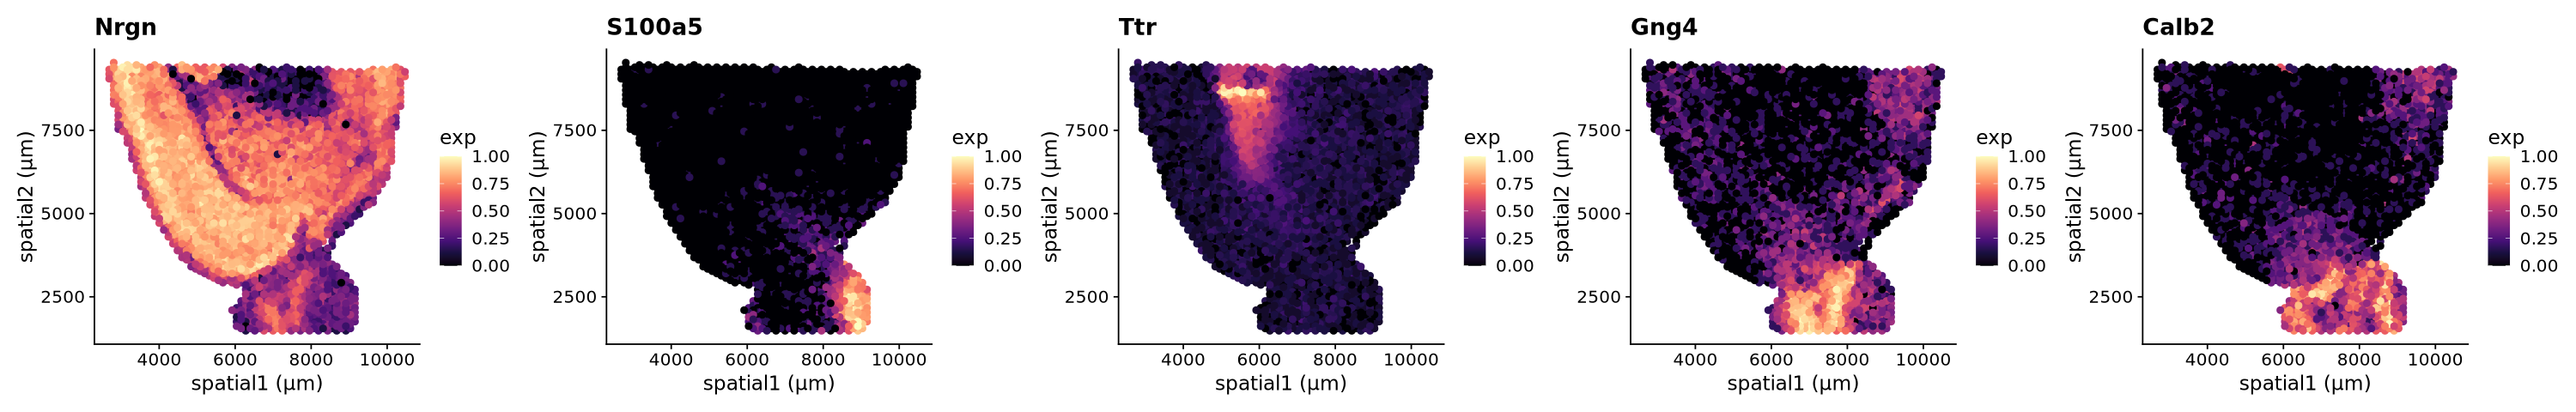

In [4]:
#可视化五个基因的表达分布
suppressMessages(library(SingleCellExperiment))
plot_exp <- function(sce, gene, pt_size=1){
    df_loc <- colData(sce)[, c("spatial1","spatial2")]
    df_exp <- as.data.frame(counts(sce)[gene, ])
    colnames(df_exp) <- c('exp')
    df_exp$exp <- rescale(log1p(df_exp$exp))
    
    df <- cbind(df_exp, df_loc)
    
    p <- ggplot(data = df, aes(x = spatial1, y = spatial2)) +
        geom_point(aes(color = exp), size = pt_size) +
        scale_colour_gradientn(colors = viridis_pal(option = "magma")(10), limits=c(0, 1)) +
        theme_cowplot() +
        labs(x = "spatial1 (μm)", y = "spatial2 (μm)") +   # 添加坐标单位
        ggtitle(gene)
    
    return(p)
}


suppressMessages(library(patchwork))

options(repr.plot.height = 4, repr.plot.width = 25)

gene_list <- rownames(ref_sce)[5:1]
plot_list <- lapply(gene_list, function(gene) {
    plot_exp(ref_sce, gene = gene, pt_size = 1.7)
})

# 横向拼图
wrap_plots(plot_list, ncol = 5)

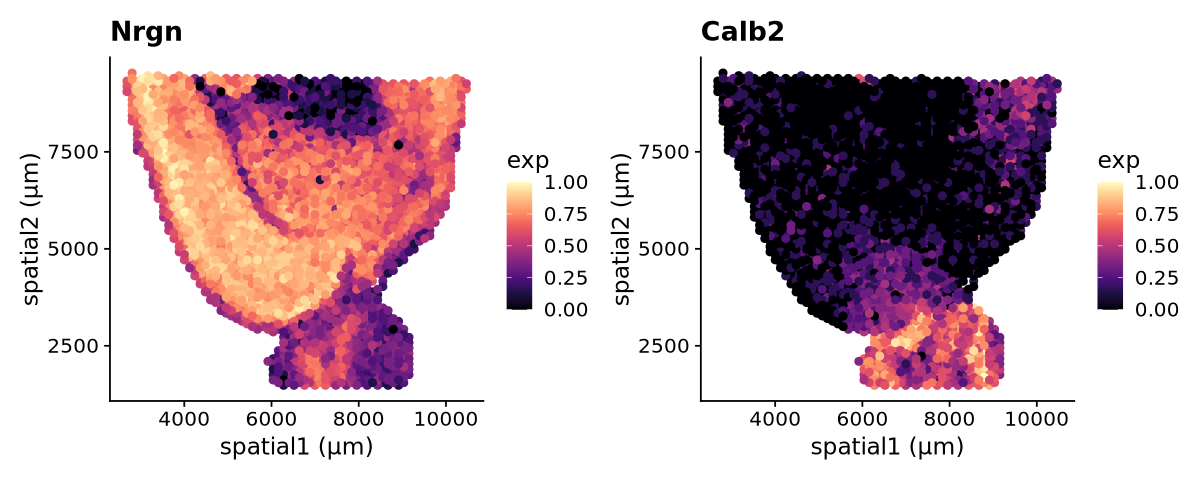

In [5]:
options(repr.plot.height = 4, repr.plot.width = 10)
library(patchwork)

p1 <- plot_exp(ref_sce, gene = "Nrgn", pt_size = 1.7)
p2 <- plot_exp(ref_sce, gene = "Calb2", pt_size = 1.7)

print(p1 + p2)

In [6]:
ref_sce

class: SingleCellExperiment 
dim: 200 2696 
metadata(0):
assays(2): counts logcounts
rownames(200): Calb2 Gng4 ... Gprin1 Pcsk1n
rowData names(0):
colnames(2696): AAACAAGTATCTCCCA-1 AAACACCAATAACTGC-1 ...
  TTGTTTCACATCCAGG-1 TTGTTTCCATACAACT-1
colData names(12): orig.ident nCount_Spatial ... spatial2 cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [7]:
set.seed(2024)

In [8]:
# 加载基础包（进度条依赖utils包，无需额外安装）
library(utils)

# 1. 构建用于边际拟合的数据（添加进度提示）
cat("开始构建边际拟合的输入数据...\n")
ref_data <- construct_data(
    sce = ref_sce,
    assay_use = "counts",
    celltype = "cell_type",
    pseudotime = NULL,
    spatial = c("spatial1", "spatial2"),
    other_covariates = NULL,
    corr_by = "1"
)
cat("✅ 输入数据构建完成！\n\n")

# 2. 用高斯过程模型拟合每个基因的表达（打印进度提示）
cat("开始用高斯过程模型拟合每个基因的表达（n_cores=2）...\n")
ref_marginal <- fit_marginal(
    data = ref_data,
    predictor = "gene",
    mu_formula = "s(spatial1, spatial2, bs = 'gp', k = 500)", 
    sigma_formula = "1",
    family_use = "nb",
    n_cores = 2,
    usebam = FALSE,
    trace = TRUE  # 保留原trace参数，输出模型拟合的原始日志
)
cat("✅ 基因表达模型拟合完成！\n\n")

# 3. 计算每个基因模型的解释度（deviance explained）+ 进度条
cat("开始计算每个基因模型的解释度...\n")
n_gene <- length(ref_marginal)  # 获取基因总数
pb <- txtProgressBar(min = 0, max = n_gene, style = 3)  # 创建进度条

dev_explain <- sapply(seq_along(ref_marginal), function(i){
  x <- ref_marginal[[i]]
  sum_res <- summary(x$fit)  # 重命名避免与base::sum冲突
  setTxtProgressBar(pb, i)   # 更新进度条
  return(sum_res$dev.expl)   
})
close(pb)  # 关闭进度条
names(dev_explain) <- names(ref_marginal)  # 为解释度向量命名
cat("\n✅ 解释度计算完成！\n\n")

# 4. 按解释度排序并筛选高变基因（自动适配基因数，避免越界）
dev_ordered <- order(dev_explain, decreasing = TRUE)
num_de <- min(50, length(dev_explain))  # 适配基因数不足50的情况
ordered <- dev_explain[dev_ordered]
sel_genes <- names(ordered)[1:num_de]
cat(paste0("已按解释度排序，选取前", num_de, "个高变基因：", paste(sel_genes, collapse = ", "), "\n\n"))

# 5. 提取高变基因的参数（打印进度提示）
cat("开始提取高变基因的参数（n_cores=5，family_use=nb）...\n")
ref_para <- extract_para(
    sce = ref_sce,
    marginal_list = ref_marginal,
    n_cores = 5,
    family_use = "nb",
    new_covariate = ref_data$newCovariate,
    data = ref_data$dat
)
cat("✅ 高变基因参数提取完成！\n\n")

# 最终完成提示
cat("\n🎉 所有分析步骤执行完成！\n")

开始构建边际拟合的输入数据...
✅ 输入数据构建完成！

开始用高斯过程模型拟合每个基因的表达（n_cores=2）...
✅ 基因表达模型拟合完成！

开始计算每个基因模型的解释度...
  |======================================================================| 100%

✅ 解释度计算完成！

已按解释度排序，选取前50个高变基因：Ttr, S100a5, Cck, Nrgn, Slc17a7, Ppp1r1b, Gpr88, Penk, Pcp4, Olfm1, Camk2n1, Mbp, Stmn1, Gng4, Nptxr, Pde10a, Calb2, Vsnl1, Snap25, Doc2g, Pde1b, 1110008P14Rik, Rgs9, 3110035E14Rik, Hpca, Camk2a, Chn1, Enpp2, Tac1, Basp1, Nrn1, Scn4b, Ywhah, Cdhr1, Arpp21, Slc30a3, Enc1, Calm2, Cox8a, Pcp4l1, Ppp3ca, Calm1, Adora2a, Bc1, Ttc9b, Fabp7, Clstn1, Prkar1b, Selenow, Scn1b

开始提取高变基因的参数（n_cores=5，family_use=nb）...
✅ 高变基因参数提取完成！


🎉 所有分析步骤执行完成！


In [9]:
ref_sce <- ref_sce[sel_genes, ]
ref_sce

class: SingleCellExperiment 
dim: 50 2696 
metadata(0):
assays(2): counts logcounts
rownames(50): Ttr S100a5 ... Selenow Scn1b
rowData names(0):
colnames(2696): AAACAAGTATCTCCCA-1 AAACACCAATAACTGC-1 ...
  TTGTTTCACATCCAGG-1 TTGTTTCCATACAACT-1
colData names(12): orig.ident nCount_Spatial ... spatial2 cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [10]:
# 加载基础包（若已加载可跳过）
library(utils)

# ===================== 关键前提：复用已计算的变量 =====================
# 确保以下变量已存在（你之前运行代码的输出）：
# ref_data、ref_marginal、sel_genes、ref_data$dat、ref_data$newCovariate

# ===================== 1. 拟合高斯Copula模型（示例代码核心新增步骤） =====================
cat("开始拟合高斯Copula模型（仅针对前", length(sel_genes), "个高解释度基因，n_cores=2）...\n")
# 筛选高解释度基因对应的边际模型和sce对象（减少计算量，聚焦核心基因）
ref_marginal_sel <- ref_marginal[sel_genes]  # 仅保留高变基因的边际模型
sce_sel <- ref_sce[sel_genes, ]  # 仅保留高变基因的表达矩阵

ref_copula <- fit_copula(
    sce = sce_sel,  # 高变基因子集
    assay_use = "counts",
    marginal_list = ref_marginal_sel,  # 高变基因的边际模型
    family_use = "nb",
    copula = "gaussian",
    n_cores = 2,
    input_data = ref_data$dat  # 复用已预处理的输入数据
)
cat("✅ 高斯Copula模型拟合完成！\n\n")

# ===================== 2. 重新提取高变基因参数（可选：覆盖原ref_para，仅保留高变基因参数） =====================
cat("开始提取高变基因的完整参数（n_cores=5）...\n")
ref_para_sel <- extract_para(
    sce = sce_sel,
    marginal_list = ref_marginal_sel,
    n_cores = 5,
    family_use = "nb",
    new_covariate = ref_data$newCovariate,
    data = ref_data$dat
)
cat("✅ 高变基因参数提取完成！\n\n")

# ===================== 3. 结果总结提示 =====================
cat("🎉 所有新增步骤执行完成！\n")
cat("- 拟合Copula模型的基因数：", length(sel_genes), "\n")
cat("- 高解释度基因列表：", paste(sel_genes, collapse = ", "), "\n")
cat("- 生成的核心对象：\n")
cat("  ① ref_copula：高斯Copula模型（捕捉高变基因间的依赖关系）\n")
cat("  ② ref_para_sel：高变基因的边际模型参数（可用于后续模拟数据生成）\n")

开始拟合高斯Copula模型（仅针对前 50 个高解释度基因，n_cores=2）...


Convert Residuals to Multivariate Gaussian

Converting End

Copula group 1 starts



✅ 高斯Copula模型拟合完成！

开始提取高变基因的完整参数（n_cores=5）...
✅ 高变基因参数提取完成！

🎉 所有新增步骤执行完成！
- 拟合Copula模型的基因数： 50 
- 高解释度基因列表： Ttr, S100a5, Cck, Nrgn, Slc17a7, Ppp1r1b, Gpr88, Penk, Pcp4, Olfm1, Camk2n1, Mbp, Stmn1, Gng4, Nptxr, Pde10a, Calb2, Vsnl1, Snap25, Doc2g, Pde1b, 1110008P14Rik, Rgs9, 3110035E14Rik, Hpca, Camk2a, Chn1, Enpp2, Tac1, Basp1, Nrn1, Scn4b, Ywhah, Cdhr1, Arpp21, Slc30a3, Enc1, Calm2, Cox8a, Pcp4l1, Ppp3ca, Calm1, Adora2a, Bc1, Ttc9b, Fabp7, Clstn1, Prkar1b, Selenow, Scn1b 
- 生成的核心对象：
  ① ref_copula：高斯Copula模型（捕捉高变基因间的依赖关系）
  ② ref_para_sel：高变基因的边际模型参数（可用于后续模拟数据生成）


In [11]:
sim_count <- simu_new(
        sce = ref_sce,
        mean_mat = ref_para$mean_mat,
        sigma_mat = ref_para$sigma_mat,
        zero_mat = ref_para$zero_mat,
        quantile_mat = NULL,
        copula_list = ref_copula$copula_list,
        n_cores = 1,
        family_use = "nb",
        input_data = ref_data$dat,
        new_covariate = ref_data$newCovariate,
        important_feature = rep(TRUE, dim(ref_sce)[1]),
        filtered_gene = NULL)

sim_sce <- SingleCellExperiment(list(counts = sim_count), 
                                colData = ref_data$newCovariate)

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts



In [12]:
# generate non-spatially variable mean values with shuffling
shuffle_idx <- sample(nrow(ref_para$mean_mat))
non_de_mat <- ref_para$mean_mat[shuffle_idx, ]

In [13]:
# simulate data with varied spatial variability
count <- lapply(seq(0, 1.0, 0.1), function(alpha){
    sim_count <- simu_new(
        sce = ref_sce,
        mean_mat =  alpha * ref_para$mean_mat + (1 - alpha) * non_de_mat,
        sigma_mat = ref_para$sigma_mat,
        zero_mat = ref_para$zero_mat,
        quantile_mat = NULL,
        copula_list = ref_copula$copula_list,
        n_cores = 1,
        family_use = "nb",
        input_data = ref_data$dat,
        new_covariate = ref_data$newCovariate,
        important_feature = rep(TRUE, dim(ref_sce)[1]),
        filtered_gene = NULL)

    rownames(sim_count) <- paste0(rownames(sim_count), "_", alpha)
    
    return(sim_count)

}) %>% do.call(rbind, .)

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts



In [ ]:
options(repr.plot.height = 4, repr.plot.width = 25)
library(SingleCellExperiment)
library(patchwork)

alphas <- seq(0, 1.0, 0.2)
gene_names <- unique(sub("_.*", "", rownames(count)))  # 获取所有基因名

for (gene in gene_names) {
    plot_list <- lapply(alphas, function(alpha) {
        idx <- grep(paste0("^", gene, "_", alpha, "$"), rownames(count))
        sce_tmp <- SingleCellExperiment(list(counts = count[idx, , drop=FALSE]), 
                                        colData = ref_data$newCovariate)
        plot_exp(sce_tmp, gene = rownames(count)[idx][1], pt_size = 1.5) +
            ggtitle(paste0(gene, " (alpha = ", alpha, ")"))
    })
    print(wrap_plots(plot_list, ncol = length(alphas)))
}

In [3]:
library(SingleCellExperiment)

sim_sce <- readRDS("./simulation_data_50_0.05.rds")
sim_sce

class: SingleCellExperiment 
dim: 1050 2696 
metadata(0):
assays(1): counts
rownames(1050): Ttr_0 S100a5_0 ... Selenow_1 Scn1b_1
rowData names(0):
colnames(2696): AAACAAGTATCTCCCA-1 AAACACCAATAACTGC-1 ...
  TTGTTTCACATCCAGG-1 TTGTTTCCATACAACT-1
colData names(3): cell_type spatial1 spatial2
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [14]:
library(SingleCellExperiment)

# 读取对象
sce <- readRDS("./data/simulation_data_50_0.1.rds")

# 导出表达矩阵
write.csv(as.matrix(counts(sce)), file = "simulation_data_50_0.1_counts.csv")

# 导出元数据
write.csv(as.data.frame(colData(sce)), file = "simulation_data_50_0.1_coldata.csv")

In [7]:
suppressMessages(library(SingleCellExperiment))
plot_exp <- function(sce, gene, pt_size=1){
    df_loc <- colData(sce)[, c("spatial1","spatial2")]
    df_exp <- as.data.frame(counts(sce)[gene, ])
    colnames(df_exp) <- c('exp')
    df_exp$exp <- rescale(log1p(df_exp$exp))
    
    df <- cbind(df_exp, df_loc)
    
    p <- ggplot(data = df, aes(x = spatial1, y = spatial2)) +
        geom_point(aes(color = exp), size = pt_size) +
        scale_colour_gradientn(colors = viridis_pal(option = "magma")(10), limits=c(0, 1)) +
        theme_cowplot() +
        labs(x = "spatial1 (μm)", y = "spatial2 (μm)") +   # 添加坐标单位
        ggtitle(gene)
    
    return(p)
}


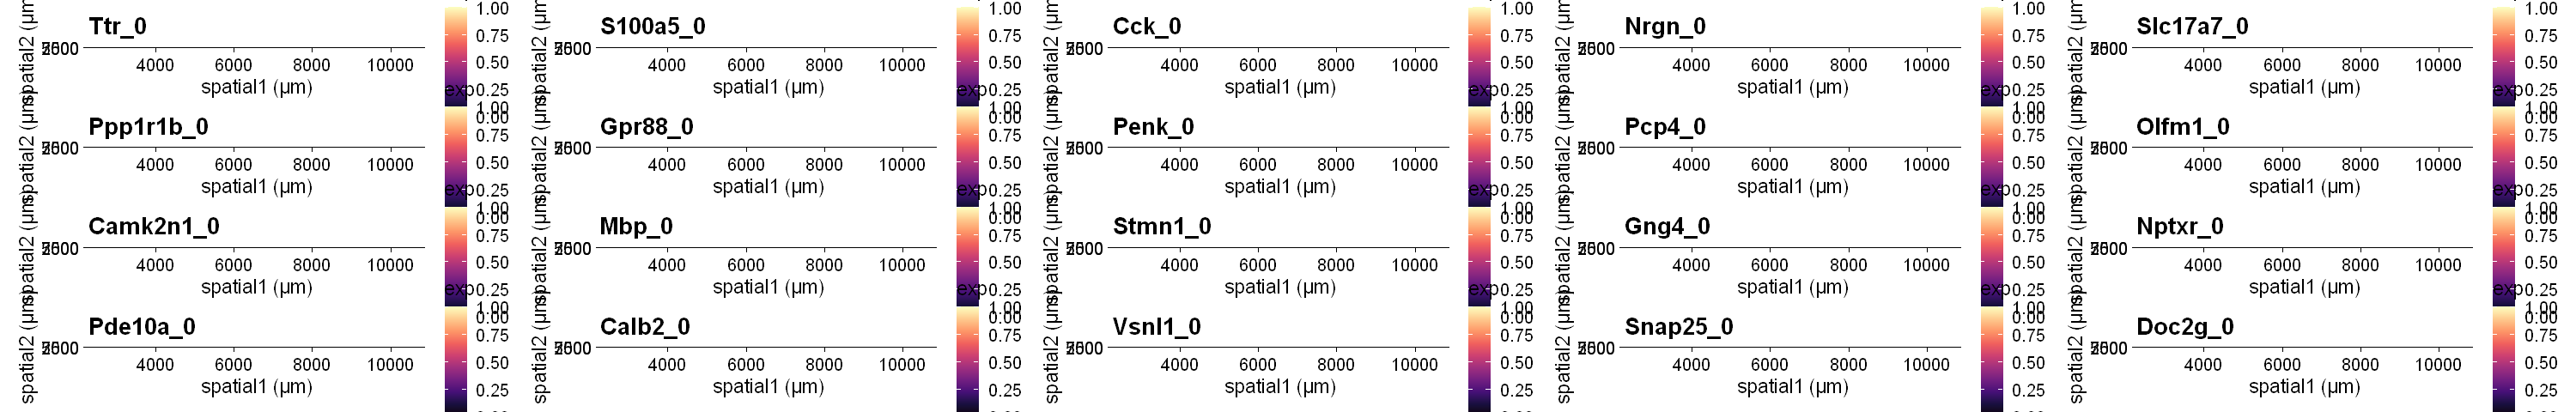

In [11]:
suppressMessages(library(patchwork))

options(repr.plot.height = 4, repr.plot.width = 25)

gene_list <- rownames(sim_sce)[1:20]
plot_list <- lapply(gene_list, function(gene) {
    plot_exp(sim_sce, gene = gene, pt_size = 1.7)
})

# 横向拼图
wrap_plots(plot_list, ncol = 5)